# Topic Analysis

It is straightforward to use the same approach for topic analysis (e.g., using the Reuters newswire dataset).


Load the data and preprocess them!


In [1]:
from keras.datasets import reuters
from keras.preprocessing import sequence
from keras.utils import to_categorical

(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=20000)
X_train = sequence.pad_sequences(X_train, maxlen=1000)
X_test = sequence.pad_sequences(X_test, maxlen=1000)
y_train, y_test = to_categorical(y_train, 46), to_categorical(y_test, 46)


/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Let's try the simplest model (Average word embedding):

In [2]:
from keras.models import Sequential
from keras.layers import Masking, GlobalAveragePooling1D, Embedding, Dense
from keras.optimizers import Adam

model = Sequential()
model.add(Masking(mask_value=0, input_shape=(1000,)))
model.add(Embedding(20000, 64, input_length=1000))
model.add(GlobalAveragePooling1D())

model.add(Dense(500, activation='relu'))
model.add(Dense(46, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
print(model.summary())
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128, verbose=2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 64)          1280000   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               32500     
_________________________________________________________________
dense_2 (Dense)              (None, 46)                23046     
Total params: 1,335,546
Trainable params: 1,335,546
Non-trainable params: 0
_________________________________________________________________
None
Train on 8982 samples, validate on 2246 samples
Epoch 1/30
 - 2s - loss: 2.8835 - acc: 0.3470 - val_loss: 2.3724 - val_acc: 0.3

Let's extract the learned representation!

In [3]:
import keras.backend as K
import numpy as np

get_conv_outputs = K.function([model.layers[0].input, K.learning_phase()], [model.layers[3].output])

x_repr = [get_conv_outputs([[X_test[i]], 0])[0] for i in range(len(X_test))]
x_repr = np.float64(x_repr).reshape((X_test.shape[0], 500))
labels = np.argmax(y_test, axis=1)
print(x_repr.shape)
print(labels.shape)

(2246, 500)
(2246,)


This representation can be used for a variety of tasks (exploratory analysis, retrieval, ...). Let's use various techniques to visualize the documents in a 2-D space!

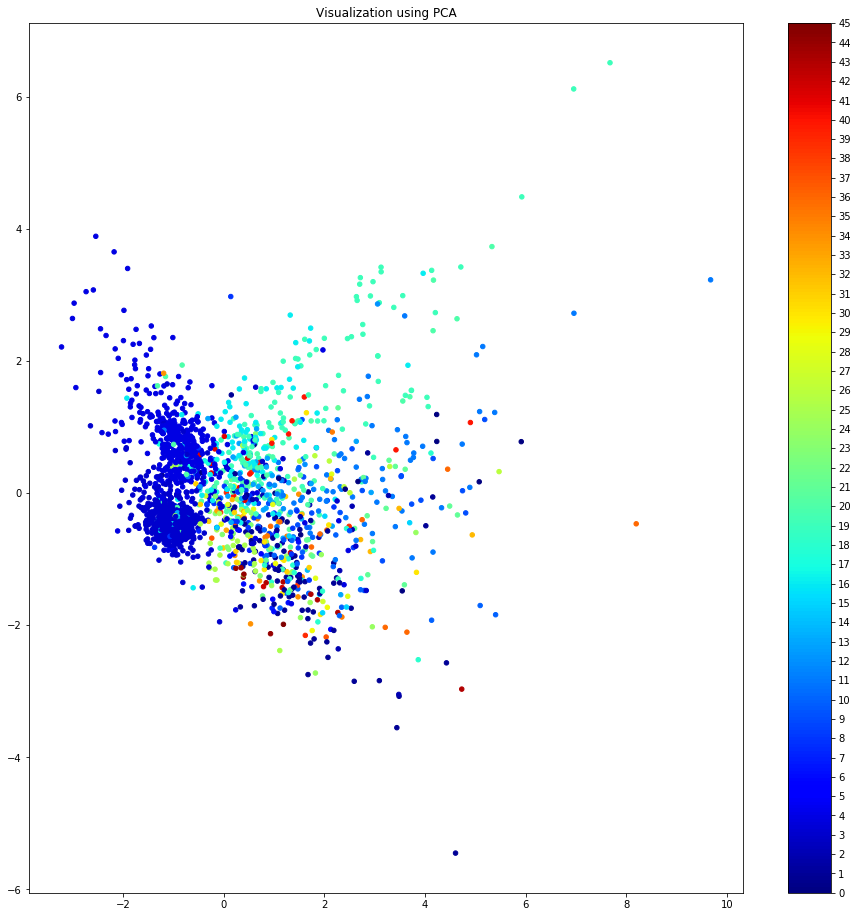

In [5]:
# Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_repr = pca.fit_transform(x_repr)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline  

fig, ax = plt.subplots(1,1, figsize=(16,16))

# make the scatter
scat = ax.scatter(pca_repr[:, 0], pca_repr[:,1], c=labels, s=20, cmap=plt.cm.jet)
cb = plt.colorbar(scat, spacing='proportional', ticks=np.linspace(0,46,47))
ax.set_title('Visualization using PCA')
plt.show()

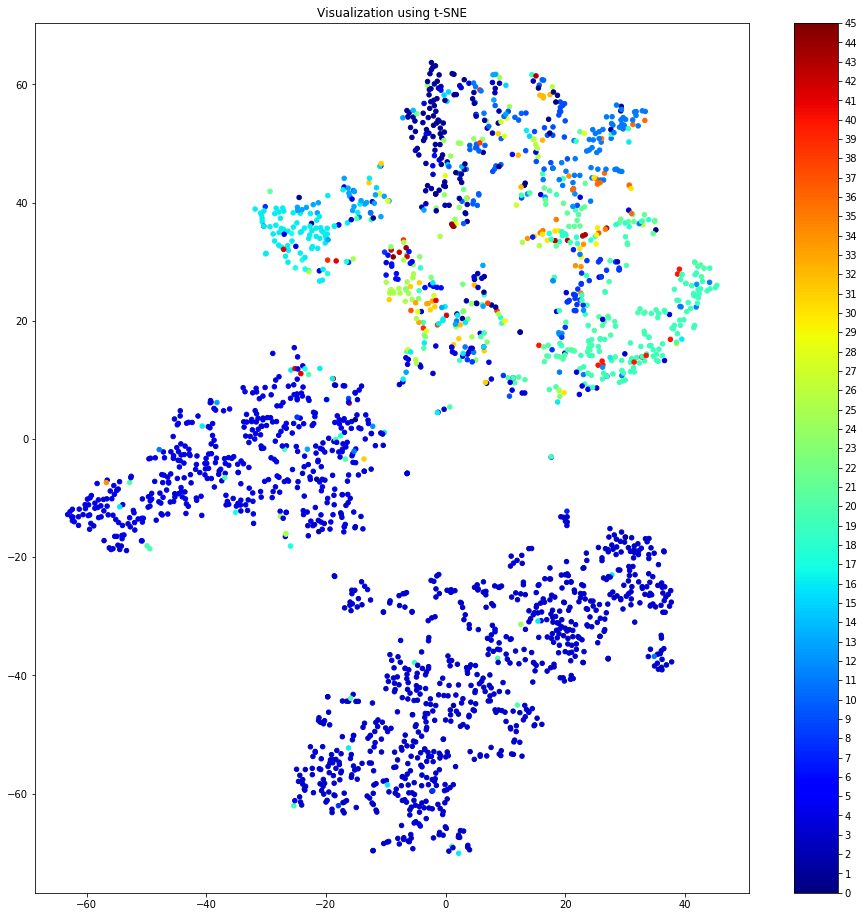

In [6]:
# Perform t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
tsne_repr = tsne.fit_transform(x_repr)

fig, ax = plt.subplots(1,1, figsize=(16,16))

# make the scatter
scat = ax.scatter(tsne_repr[:, 0], tsne_repr[:,1], c=labels, s=20, cmap=plt.cm.jet)
cb = plt.colorbar(scat, spacing='proportional', ticks=np.linspace(0,46,47))
ax.set_title('Visualization using t-SNE')
plt.show()